In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# %% [code]
%load_ext autoreload
%autoreload 2

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Input, concatenate
from tensorflow.keras.callbacks import EarlyStopping
#from ml_logic.preprocessor import data_balancing, create_model, load_and_preprocess_image, image_augmentation
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import Model, Sequential, layers, models, optimizers, callbacks

In [4]:
train = pd.read_csv('drive/MyDrive/Colab Notebooks/RFMiD_Training_Labels.csv').set_index('ID')
#test = pd.read_csv('RFMiD_Testing_Labels.csv').set_index('ID')
eval = pd.read_csv('drive/MyDrive/Colab Notebooks/RFMiD_Validation_Labels.csv').set_index('ID')

In [5]:
def data_balancing(table_link='../data/'):
    '''
    This function loads the raw data and returns a balanced dataset as two
    dictionaries.
    '''
    df = pd.read_csv(f'{table_link}RFMiD_Training_Labels.csv').set_index('ID')
    df_binary = df.loc[:, df.columns.intersection(['Disease_Risk'])]
    df_healthy = df_binary[df.Disease_Risk == 0]
    df_unhealthy = df_binary[df.Disease_Risk == 1]
    df_unhealthy_rndselection = df_unhealthy.sample(n = 401)
    frames = [df_healthy, df_unhealthy_rndselection]
    result = pd.concat(frames)
    return result

In [6]:
# Splitting Data

# X_train = train.drop(columns='Disease_Risk')
X_train = data_balancing(table_link='drive/MyDrive/Colab Notebooks/')
# y_train = train['Disease_Risk']
y_train = X_train
X_eval  = eval.drop(columns='Disease_Risk')
y_eval = eval['Disease_Risk']

In [7]:
print(X_train.sample(5))
print(X_train.shape)
print(y_train.sample(5))
print(y_train.shape)

      Disease_Risk
ID                
325              0
1479             1
1052             0
1553             0
1267             1
(802, 1)
      Disease_Risk
ID                
1650             1
753              1
1086             0
1662             1
420              0
(802, 1)


In [8]:
def load_image(image_id, image_folder, target_size=(224, 224)):
    """
    Load and preprocess an image given its ID.
    """

    image_path = os.path.join(image_folder, f'{image_id}.png')
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)

    return image

In [9]:
# Loading Images

image_folder = 'drive/MyDrive/Colab Notebooks/training_images'
eval_image_folder = 'drive/MyDrive/Colab Notebooks/eval_images'
images = np.array([load_image(row_id,image_folder) for row_id in X_train.index])
eval_images = np.array([load_image(row_id,eval_image_folder) for row_id in X_eval.index])

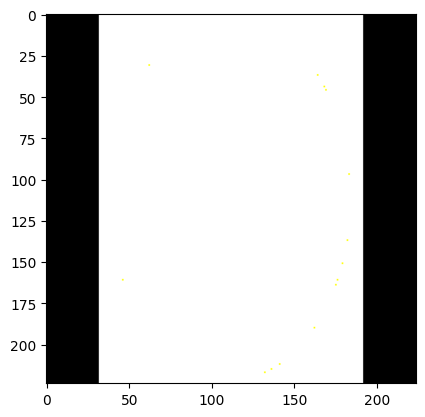

In [10]:
plt.imshow(images[0])

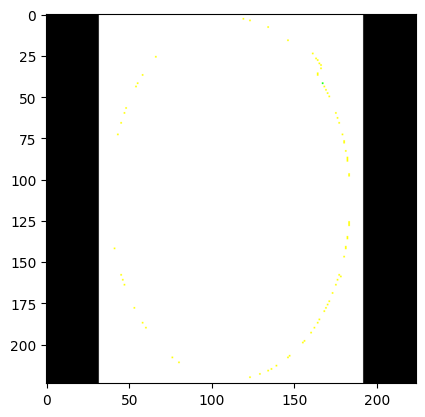

In [11]:
plt.imshow(eval_images[0])

In [12]:
def image_augmentation(images):

    data_augmentation = models.Sequential([
    # layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.001),
    layers.RandomTranslation(0.02, 0.02),
    layers.RandomRotation(0.1)
    ])

    # images = tf.expand_dims(images, 0)

    augmented_images = data_augmentation(images)

    # images = tf.squeeze(images, 0)
    return augmented_images

In [13]:
augmented_images = image_augmentation(images)
augmented_eval_images = image_augmentation(eval_images)

In [14]:
# print(augmented_images.shape)
# print(augmented_eval_images.shape)

In [15]:
# plt.imshow(augmented_images[0])

In [16]:
# plt.imshow(augmented_eval_images[0])

In [17]:
##### DATA AUGMENTATION CODE FROM CNN RECAP#####
data_augmentation = models.Sequential()

data_augmentation.add(layers.RandomFlip("horizontal"))
data_augmentation.add(layers.RandomZoom(0.1))
data_augmentation.add(layers.RandomTranslation(0.2, 0.2))
data_augmentation.add(layers.RandomRotation(0.1))

In [18]:
base_model = VGG16(weights = "imagenet", include_top = False, input_shape = (224, 224, 3))

58889256/58889256 [==============================] - 4s 0us/step


In [25]:
#model = create_model((224,224,3)) ##first model


####test with VGG model addition####
image_input = layers.Input(shape=(224, 224, 3))
#x = data_augmentation(image_input) # We still have our data augmentation layers
x = preprocess_input(image_input) # Then a preprocessing layer specifically designed for the VGG16
x = base_model(x) # Then our transfer learning model

# x = Conv2D(64, (3, 3), activation='relu', padding = "same")(x)
# x = MaxPooling2D((2, 2),padding = "same")(x)
# x = Conv2D(32, (3, 3), activation='relu', padding = "same")(x)
# x = MaxPooling2D((2, 2),padding = "same")(x)
x = Conv2D(1024, (3, 3), activation='relu', padding = "same")(x)
x = MaxPooling2D((2, 2),padding = "same")(x)

x = Flatten()(x)

z = Dense(64, activation='relu')(x)
#z = layers.Dropout(0.3)(z)
z = Dense(32, activation='relu')(z)
#z = layers.Dropout(0.3)(z)
z = Dense(1, activation='sigmoid')(z)

model_test = Model(inputs=image_input, outputs=z)
# And we freeze the VGG16 model
base_model.trainable = False

In [20]:
#del model_test, x, z

In [22]:
optimizer = optimizers.legacy.Adam(learning_rate=0.001)

In [23]:
optimizer2 = optimizers.RMSprop

In [27]:
#model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model_test.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['Precision', 'accuracy'])

In [28]:
# model_3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
# model_4.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['precision'])

In [30]:
# model.summary()

In [31]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [32]:
model_test.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 1024)        4719616   
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 1024)        0   

In [33]:
# model_3.summary()

In [34]:
# model_4.summary()

In [35]:
# es = EarlyStopping(
#     monitor='val_accuracy',
#     min_delta=0.05,
#     patience=10,
# )

In [36]:
es2 = EarlyStopping(
    monitor='val_loss',
    #restore_best_weights=True,
    patience=10,
)

In [37]:
LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=3, verbose=1, min_lr=0)

In [38]:
# history1 = model.fit(
#     augmented_images, y_train,
#     validation_data=(augmented_eval_images, y_eval),
#     epochs=100,
#     batch_size=32,
#     callbacks=[es]
# )

#accuracy before with 20 epochs and batch of 55:

In [39]:
history3 = model_test.fit(
    augmented_images, y_train,
    validation_data=(augmented_eval_images, y_eval),
    epochs=50,
    batch_size=32,
    callbacks=[es2, LRreducer]
)

#accuracy before with 20 epochs and batch of 55:0.5436
#new_acc = 0.8915
#new_acc = 0.95
#new_acc = 0.79

Epoch 1/50
26/26 [==============================] - 21s 281ms/step - loss: 6.6913 - precision: 0.6046 - accuracy: 0.6022 - val_loss: 0.5617 - val_precision: 0.9760 - val_accuracy: 0.7672 - lr: 0.0010
Epoch 2/50
26/26 [==============================] - 9s 353ms/step - loss: 0.4465 - precision: 0.7814 - accuracy: 0.8017 - val_loss: 0.4920 - val_precision: 0.9809 - val_accuracy: 0.7609 - lr: 0.0010
Epoch 3/50
26/26 [==============================] - 6s 233ms/step - loss: 0.3016 - precision: 0.9088 - accuracy: 0.8803 - val_loss: 0.4565 - val_precision: 0.9819 - val_accuracy: 0.7906 - lr: 0.0010
Epoch 4/50
26/26 [==============================] - 6s 241ms/step - loss: 0.2228 - precision: 0.9302 - accuracy: 0.9152 - val_loss: 0.3760 - val_precision: 0.9716 - val_accuracy: 0.8328 - lr: 0.0010
Epoch 5/50
26/26 [==============================] - 6s 240ms/step - loss: 0.1868 - precision: 0.9409 - accuracy: 0.9277 - val_loss: 0.4555 - val_precision: 0.9825 - val_accuracy: 0.8109 - lr: 0.0010
Epoc

In [40]:
y_eval.value_counts()

1    506
0    134
Name: Disease_Risk, dtype: int64

In [41]:
# history4 = model_3.fit(
#     augmented_images, y_train,
#     validation_data=(augmented_eval_images, y_eval),
#     epochs=40,
#     batch_size=32,
#     callbacks=[es2, LRreducer]
# )

In [42]:
# history5 = model_4.fit(
#     augmented_images, y_train,
#     validation_data=(augmented_eval_images, y_eval),
#     epochs=40,
#     batch_size=32,
#     callbacks=[es2, LRreducer]
# )

In [43]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [44]:
def plot_history_prec(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('precision')
    ax[1].plot(history.epoch, history.history["precision"], label="Train prec")
    ax[1].plot(history.epoch, history.history["val_precision"], label="Validation prec")
    ax[0].legend()
    ax[1].legend()

In [45]:
def plot_compare_history(history, name_history, history_1, name_history_1):

    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    ax[0].set_title('loss')

    ax[0].plot(history.epoch, history.history["loss"], label="Train loss " + name_history)
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss " + name_history)

    ax[0].plot(history_1.epoch, history_1.history["loss"], label="Train loss " + name_history_1)
    ax[0].plot(history_1.epoch, history_1.history["val_loss"], label="Validation loss " + name_history_1)

    ax[1].set_title('Accuracy')

    ax[1].plot(history.epoch, history.history["accuracy"], label="Train Accuracy " + name_history)
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy " + name_history)

    ax[1].plot(history_1.epoch, history_1.history["accuracy"], label="Train Accuracy " + name_history_1)
    ax[1].plot(history_1.epoch, history_1.history["val_accuracy"], label="Validation Accuracy " + name_history_1)

    ax[0].legend()
    ax[1].legend()

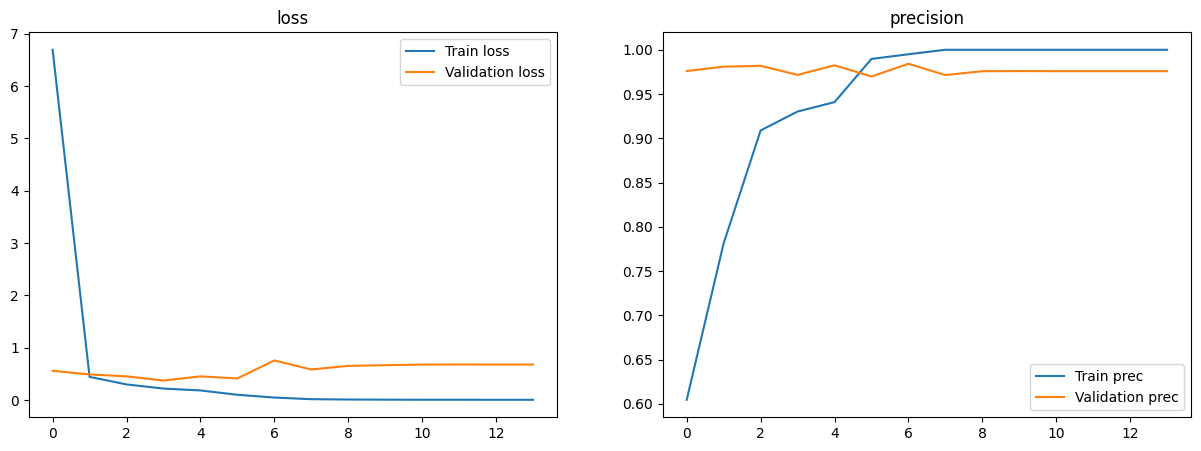

In [46]:
#plot_history(history3)
plot_history_prec(history3)

In [47]:
# plot_history(history4)

In [48]:
# plot_history(history5)

In [50]:
#model.evaluate(augmented_eval_images, y_eval)

In [ ]:
#model_test.evalutate(augmented_eval_images, y_eval)

In [60]:
model_test.save("/content/drive/MyDrive/Colab Notebooks/saved_model/model_2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
